In [16]:
#==========================#
# Import relevant packages #
#==========================#


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import erfinv
from iminuit import Minuit
from scipy.stats import chi2
from scipy.stats import binom
%matplotlib inline
from scipy.stats import poisson

# Report 1 - Estimating Parameters with MC Generated Samples

## Description

The report based around a particle decay of $X \rightarrow D$, and a parameter related to the matter/anti-matter asymmetry of the Universe will be measured.

The PDF of the relevant particle decay is described by:
$$
P(t;\tau,\Delta m_s, V) \propto (1+V\sin{(\Delta mt)}) \times \exp{-\frac{t}{\tau}}
$$
where

* $t$ is the observable quantity - the decay time of each decay.
* $\tau$ is a lifetime parameter.
* $\Delta m$ is a mass difference parameter which leads to sinusoidal oscillations superimposed on the exponential decay.
* $V$ is a parameter which measures matter/anti-matter asymmetry and has the value zero if
the universe is symmetric.

And the nominal value of the parameters are:

* $\tau = 1.5$
* $\Delta m = 20.0$
* $V = 0.1$

We will first plot the PDF to see the distribution within the range 0 to 10. At this stage, something else in addition is to vary the parameters a little to see how change of each parameter affects our PDF distribution.

In [20]:
#==================================================#
# Create a function returning the PDF distribution #
#==================================================#

def pdf_distribution(t, tau, delta_m, V):
    return ( (1 + V*np.sin(delta_m*t))*np.exp(-t/tau) )

In [56]:
#=====================================================#
# Define parameters for plotting the PDF distribution #
#=====================================================#

loBound = 0.
hiBound = 10.
n_interval = 1000
t = np.linspace(loBound, hiBound, n_interval, endpoint=True)
# nominal values for the parameters
tau1 = 1.5
delta_m1 = 20.
v1 = 0.1
# Three more sets of parameters to see how our PDF distribution change
tau2 = 3.
delta_m2 = 10.
v2 = 1.

tau3 = 2.
delta_m3 = 10.
v3 = 4.

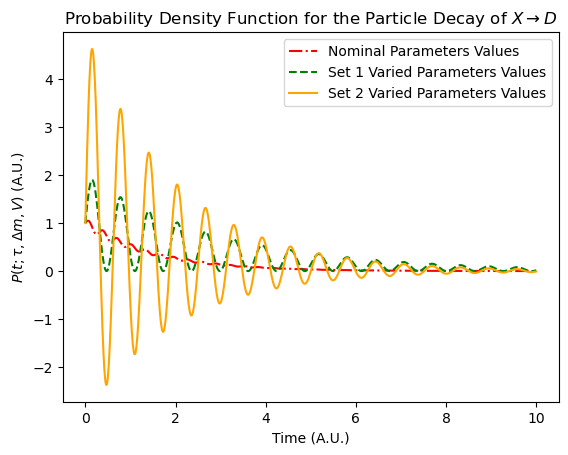

In [57]:
#===========================#
# Plot the PDF distribution #
#===========================#

plt.plot(t, pdf_distribution(t, tau1, delta_m1, v1), ls='-.', color='r', label='Nominal Parameters Values')
plt.plot(t, pdf_distribution(t, tau2, delta_m2, v2), ls='--', color='g', label='Set 1 Varied Parameters Values')
plt.plot(t, pdf_distribution(t, tau3, delta_m3, v3), color='orange', label='Set 2 Varied Parameters Values')
plt.title(r'Probability Density Function for the Particle Decay of $X \rightarrow D$')
plt.xlabel('Time (A.U.)')
plt.ylabel(r'$P(t;\tau,\Delta m, V)$ (A.U.)')
plt.legend()
plt.show()

The above plot shows the distribution of our PDF that characterizes the particle decay, and three of them have different parameters, this is to show how the parameters change the waveform of our PDF distribution.

As seen from above, and equation from the top description section. It appears that the function is decaying in a sinusoidal way. And the parameters ($\tau, \Delta m, V$) represents  the decay constant, the angular frequency and the amplitude, respectively.

## Question 1

In this question, we'll use toy Monte Carlo event generation to simulate multiple pseudo-experiments, and use this method to determine the expected statistical precision with which one could measure each of the parameters with 10000 events.

The first step here is to create a PDF class which generates random points based on the PDF function given in the description for the relevant particle decay, and also contain methods/functions in setting different parameters.

In [58]:
#==============================================================================================#
# Create a PDF class used to model the oscillatory exponential decay pdf function as described #
#==============================================================================================#

class DecayPDF(object):

    # Constructor
    def __init__(self, loBound, hiBound, tau, delta_m, V):
        self.loBound = loBound
        self.hiBound = hiBound
        self.tau = tau
        self.delta_m = delta_m
        self.V = V
    
        # initialize distribution mass array
        self.mass = []

    
    #———————————————————————————————————————————#
    # Function used to find maximum of function #
    #———————————————————————————————————————————#

    def find_max(self):
        # First generate a grid of x points
        x = np.linspace(self.loBound, self.hiBound, endpoint=True, num=grid)
        # Next, evaluate the function at all the x, and return the maximum
        y = self.evaluate(x)
        return y.max()

    
    #———————————————————————————————————————————#
    # Function used to find minimum of function #
    #———————————————————————————————————————————#

    def find_min(self):
        # First generate a grid of x points
        x = np.linspace(self.loBound, self.hiBound, endpoint=True, num=grid)
        # Next, evaluate the function at all the x, and return the minimum
        y = self.evaluate(x)
        return y.min()


    #————————————————————————————————————————————————#
    # Function used to set passed vars as parameters #
    #————————————————————————————————————————————————#

    def setParameters(self, tau, delta_m, V):
        self.tau = tau
        self.delta_m = delta_m
        self.V = V


    #————————————————————————————————————————————————#
    # Evaluate the PDF and return un-normalized vals #
    #————————————————————————————————————————————————#

    def evaluate(self, t):
        return ( (1+self.V*np.sin(self.delta_m*t))*np.exp(-t/self.tau) )

    
    #————————————————————————————————————————————————————————————————————————————————————————————#
    # From the PDF distribution for our decay, sample random points (here using the 'box' method #
    #————————————————————————————————————————————————————————————————————————————————————————————#

    def next(self):
        doLoop = True
        while (doLoop):
            x = np.random.uniform(self.loBound, self.hiBound)
            y1 = self.evaluate(x)
            y2 = np.random.uniform(self.find_min(), self.find_max())
            # now consider the acceptance if y1 is above x-axis
            if (y2<y1):
                filtered_x = x
                self.mass.append(x)
                return filtered_x